# Sentiment Analysis using Gaussian processes



Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# [1]. Reading Data

In [63]:

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [64]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [65]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [66]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [67]:
display['COUNT(*)'].sum()

393063

#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [68]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [69]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [70]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [71]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [72]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [73]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [74]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [75]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [76]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [77]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [78]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [79]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [80]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [81]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [82]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [83]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [02:06<00:00, 2867.62it/s]


In [24]:
#preprocessed_reviews

In [84]:
final['CleanedText']=preprocessed_reviews
#final['Summary']=preprocessed_Summary

In [86]:
#Store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True)

# Featurization 

In [3]:
conn = sqlite3.connect('final.sqlite')
final = pd.read_sql_query("""
SELECT *
FROM Reviews""", conn)


In [4]:
from sklearn.model_selection import train_test_split
X=final['CleanedText']
y=final['Score']
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)


# [4] Featurization

## [4.4] Word2Vec

In [5]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in final['CleanedText']:
    list_of_sentance.append(sentance.split())

In [6]:
###maually building wordtovectors
w2v_model_m=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)

In [ ]:
## using pretrained model by google Goole 

In [17]:
###loading predefined 
w2v_model_g=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [20]:
w2v_model_g.wv.most_similar('great')

[('terrific', 0.7989331483840942),
 ('fantastic', 0.7935211658477783),
 ('tremendous', 0.7748856544494629),
 ('wonderful', 0.7647868394851685),
 ('good', 0.7291510105133057),
 ('incredible', 0.7032873630523682),
 ('marvelous', 0.6971102952957153),
 ('phenomenal', 0.6841565370559692),
 ('amazing', 0.6634128093719482),
 ('awesome', 0.6510506868362427)]

In [28]:
w2v_model_m.wv.most_similar('great')

[('excellent', 0.9958922863006592),
 ('pretty', 0.9953159093856812),
 ('licorice', 0.9952065348625183),
 ('alternative', 0.9951536655426025),
 ('especially', 0.9951245784759521),
 ('wonderful', 0.9950419664382935),
 ('regular', 0.9949741959571838),
 ('snack', 0.9949314594268799),
 ('amazing', 0.9949156045913696),
 ('think', 0.9948455095291138)]

In [21]:
w2v_model_g.wv.most_similar('worst')

[('Worst', 0.6146092414855957),
 ('weakest', 0.6143776774406433),
 ('scariest', 0.5957258343696594),
 ('ugliest', 0.5931180715560913),
 ('best', 0.5835110545158386),
 ('bleakest', 0.5718506574630737),
 ('strongest', 0.567145586013794),
 ('nastiest', 0.5644308924674988),
 ('lousiest', 0.5631451606750488),
 ('toughest', 0.5624395608901978)]

In [23]:
w2v_model_g.wv.most_similar('computer')

[('computers', 0.7979379892349243),
 ('laptop', 0.6640493273735046),
 ('laptop_computer', 0.6548868417739868),
 ('Computer', 0.6473334431648254),
 ('com_puter', 0.6082079410552979),
 ('technician_Leonard_Luchko', 0.5662748217582703),
 ('mainframes_minicomputers', 0.5617721080780029),
 ('laptop_computers', 0.5585449934005737),
 ('PC', 0.5539618134498596),
 ('maker_Dell_DELL.O', 0.5519254207611084)]

In [90]:
w2v_model_m.wv.most_similar('computer')

[('laptop', 0.8190152645111084),
 ('downstairs', 0.7784250378608704),
 ('parked', 0.7685226798057556),
 ('mirror', 0.7642310857772827),
 ('windows', 0.7474341988563538),
 ('quietly', 0.7431715726852417),
 ('bus', 0.7367022633552551),
 ('ceiling', 0.7334750294685364),
 ('stairs', 0.7315729856491089),
 ('meetings', 0.729689359664917)]

In [27]:
w2v_model_m.wv.most_similar('great')

[('excellent', 0.9958922863006592),
 ('pretty', 0.9953159093856812),
 ('licorice', 0.9952065348625183),
 ('alternative', 0.9951536655426025),
 ('especially', 0.9951245784759521),
 ('wonderful', 0.9950419664382935),
 ('regular', 0.9949741959571838),
 ('snack', 0.9949314594268799),
 ('amazing', 0.9949156045913696),
 ('think', 0.9948455095291138)]

In [7]:
w2v_model=w2v_model_m

In [8]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
#

number of words that occured minimum 5 times  33573


## [4.4.1] Converting text into vectors using wAvg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [13]:

def avgw2vvectors(list_of_sent):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sent): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 200, you might need to change this to 300 if you use google's w2v
        cnt_words = 0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return sent_vectors

In [14]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [15]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [16]:
train_avgw2v=avgw2vvectors(list_of_sentance_train)


100%|█████████████████████████████████████████████████████████████████████████| 243994/243994 [27:42<00:00, 146.74it/s]

243994
50


In [17]:
np.save('X_train_afr_manual_w2v.npy', train_avgw2v)

In [18]:
test_avgw2v=avgw2vvectors(list_of_sentance_test)

100%|█████████████████████████████████████████████████████████████████████████| 120177/120177 [13:46<00:00, 145.48it/s]

120177
50


In [19]:
np.save('X_test_afr_manual_w2v.npy', test_avgw2v)

In [20]:
np.save('y_train',y_train)

In [21]:
np.save('y_test',y_test)

#### [4.4.1.2] TFIDF weighted W2v

In [32]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [33]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:22<00:00, 218.27it/s]


In [ ]:
np.save('data.npy', num_arr) # save
new_num_arr = np.load('data.npy') # load

# ML Algorithms

### Logistic Regression

In [1]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
#from xgboost import plot_importance
from numpy import loadtxt
#from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
import pickle
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.ensemble import GradientBoostingClassifier
import scikitplot as skplt
#from pycaret.classification import *

In [2]:
X_train=np.load("X_train_afr_manual_w2v.npy")
X_test=np.load("X_test_afr_manual_w2v.npy")
y_train=np.load("y_train.npy")
y_test=np.load("y_test.npy")

In [3]:

from sklearn.linear_model import LogisticRegression
model_lr=LogisticRegression(C=0.1,random_state=0)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
y_prob_lr = model_lr.predict_proba(X_test)

In [4]:
accuracy = accuracy_score(y_test, y_pred_lr)
print("accuracy:",accuracy)

f1score=f1_score(y_test, y_pred_lr)
print("f1-acore:",f1score)

cm=confusion_matrix(y_test, y_pred_lr)
print("confusion matrix:\n",cm)
pr=precision_score(y_test,y_pred_lr)
print("Precision:",pr)
rs=recall_score(y_test,y_pred_lr)
print("Recall_score:",rs)

accuracy: 0.9006132621050617
f1-acore: 0.9425426696684561
confusion matrix:
 [[10267  8584]
 [ 3360 97966]]
Precision: 0.9194368840919755
Recall_score: 0.9668397055050036


In [5]:
accuracy = accuracy_score(y_test, y_pred_lr)
print('Test Accuracy: {:.2%}'.format(accuracy))

Test Accuracy: 90.06%


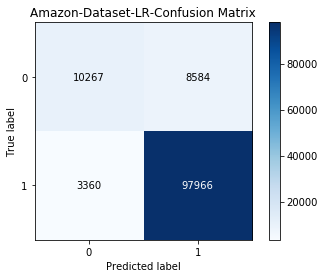

In [6]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_lr)
plt.title("Amazon-Dataset-LR-Confusion Matrix")
plt.rcParams['figure.figsize']=(8,6)
plt.show()

In [7]:
y_pred_lr = model_lr.predict(X_train)
y_prob_lr = model_lr.predict_proba(X_train)
tr_accuracy = accuracy_score(y_train, y_pred_lr)
print('Train Accuracy: {:.2%}'.format(tr_accuracy))

Train Accuracy: 90.15%


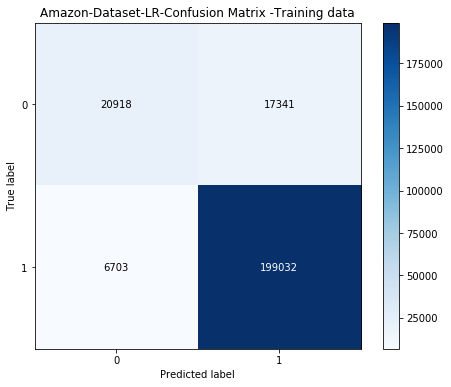

In [8]:
skplt.metrics.plot_confusion_matrix(y_train, y_pred_lr)
plt.title("Amazon-Dataset-LR-Confusion Matrix -Training data")
plt.rcParams['figure.figsize']=(8,6)
plt.show()

### Naive Bayes

In [9]:

%%time
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
#from sklearn.neighbors import KNeighborsClassifier
model_nb=BernoulliNB()
#model_nb=GaussianNB()
model_nb.fit(X_train, y_train)
#y_pred = model_nb.predict(X_test_nb)
y_pred_nb = model_nb.predict(X_test)
y_prob_nb = model_nb.predict_proba(X_test)

CPU times: user 6.05 s, sys: 556 ms, total: 6.61 s
Wall time: 459 ms


In [10]:

accuracy = accuracy_score(y_test, y_pred_nb)
print("accuracy:",accuracy)

f1score=f1_score(y_test, y_pred_nb)
print("f1-acore:",f1score)

cm=confusion_matrix(y_test, y_pred_nb)
print("confusion matrix:\n",cm)
pr=precision_score(y_test,y_pred_nb)
print("Precision:",pr)
rs=recall_score(y_test,y_pred_nb)
print("Recall_score:",rs)

accuracy: 0.8560207027967082
f1-acore: 0.9153162853297442
confusion matrix:
 [[ 9363  9488]
 [ 7815 93511]]
Precision: 0.9078826008019495
Recall_score: 0.9228727078933344


In [11]:
accuracy = accuracy_score(y_test, y_pred_nb)
print('Test Accuracy: {:.2%}'.format(accuracy))

Test Accuracy: 85.60%


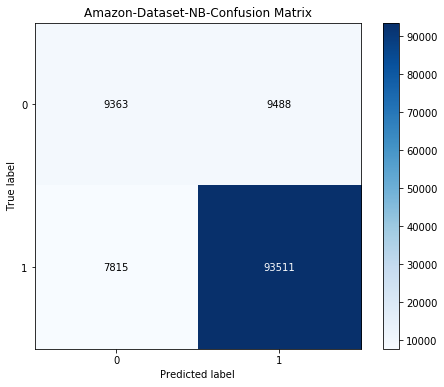

In [12]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_nb)
plt.title("Amazon-Dataset-NB-Confusion Matrix")
plt.rcParams['figure.figsize']=(8,6)
plt.show()

In [13]:
y_pred_nb = model_nb.predict(X_train)
y_prob_nb = model_nb.predict_proba(X_train)
tr_accuracy = accuracy_score(y_train, y_pred_nb)
print('Train Accuracy: {:.2%}'.format(tr_accuracy))

Train Accuracy: 85.91%


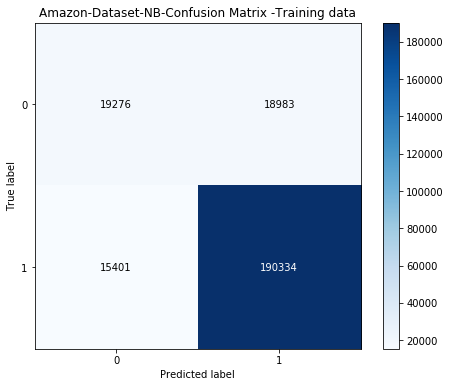

In [14]:
skplt.metrics.plot_confusion_matrix(y_train, y_pred_nb)
plt.title("Amazon-Dataset-NB-Confusion Matrix -Training data")
plt.rcParams['figure.figsize']=(8,6)
plt.show()

### Random Forest

In [7]:

from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=100,max_depth=40,random_state=0,n_jobs=-1)
model_rf.fit(X_train, y_train)
print(model_rf)
y_pred_rf = model_rf.predict(X_test)
y_prob_rf = model_rf.predict_proba(X_test)

RandomForestClassifier(max_depth=40, n_jobs=-1, random_state=0)


In [8]:
accuracy = accuracy_score(y_test, y_pred_rf)
print("accuracy:",accuracy)
f1score=f1_score(y_test, y_pred_rf)
print("f1-acore:",f1score)
cm=confusion_matrix(y_test, y_pred_rf)
print("confusion matrix:\n",cm)
pr=precision_score(y_test,y_pred_rf)
print("Precision:",pr)
rs=recall_score(y_test,y_pred_rf)
print("Recall_score:",rs)

accuracy: 0.8951796100751391
f1-acore: 0.9404349285758192
confusion matrix:
 [[ 8137 10714]
 [ 1883 99443]]
Precision: 0.9027388182321595
Recall_score: 0.9814164182934292


### TSNE Visualization

In [43]:
from sklearn.manifold import TSNE

# Picking the top 1000 points as TSNE takes a lot of time for 15K points
data_1000 = X_train
labels_1000 = y_train
#data= 
#labels= label


model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_1000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df_bin = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

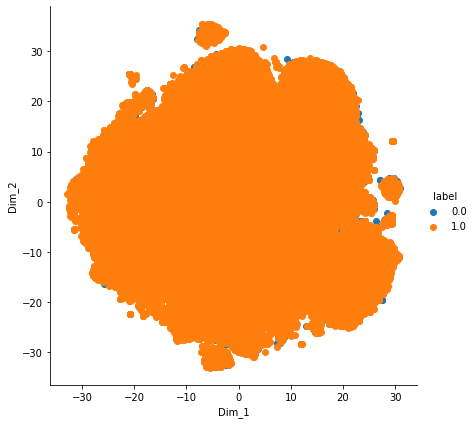

In [46]:
import seaborn as sns
sns.FacetGrid(tsne_df_bin, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [55]:
from sklearn.manifold import TSNE

# Picking the top 1000 points as TSNE takes a lot of time for 15K points
data_1000 = X_train[1:1000]
labels_1000 = y_train[1:1000]
#data= 
#labels= label


model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_1000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df_bin = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

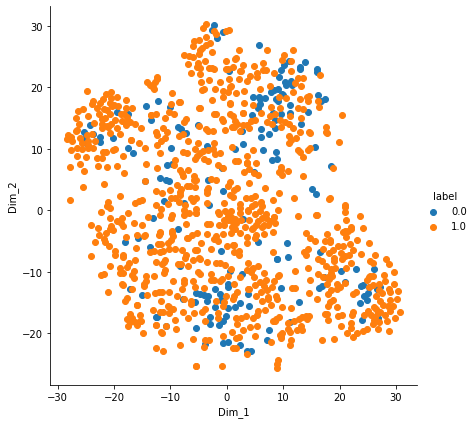

In [56]:
import seaborn as sns
sns.FacetGrid(tsne_df_bin, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

### Neural Networks

In [26]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense,Dropout,LSTM,Embedding,SimpleRNN, GRU,Activation,Flatten
from tensorflow.keras.layers import Conv1D,MaxPool1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,CSVLogger
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import sequence
from sklearn.metrics import (precision_score, recall_score,confusion_matrix,f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
import pandas as pd
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
import matplotlib.pyplot as plt
import scikitplot as skplt
#import scikitplot as skplt

In [14]:
test_size = 0.33
X_t, X_va, y_t, y_va = train_test_split(X_train, y_train, test_size=test_size, random_state=3)

In [15]:
X_tr = np.reshape(X_t, (X_t.shape[0], 1, X_t.shape[1]))
X_tst = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_val= np.reshape(X_va, (X_va.shape[0], 1, X_va.shape[1]))

In [16]:
y_tr=y = y_t.ravel()
y_tst=y_test.ravel()
y_val=y_va.ravel()

In [20]:
batch_size = 64
id=X_tr[2].shape[1] 
# define network
model_dnn3 = Sequential()
model_dnn3.add(Flatten())
model_dnn3.add(Dense(1024,input_dim=id,activation='relu'))  
model_dnn3.add(Dropout(0.01))
model_dnn3.add(Dense(768,activation='relu'))  
model_dnn3.add(Dropout(0.01))

model_dnn3.add(Dense(1))
model_dnn3.add(Activation('sigmoid'))

In [21]:
model_dnn3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.01,patience=5) ## early stoppoing

model_dnn3.fit(X_tr, y_tr, validation_data=(X_val, y_val),batch_size=batch_size, epochs=1000, callbacks=[es])
#model_dnn3.save("dnn_two_layer_model_dnn3.hdf5")

Epoch 1/1000
2555/2555 [==============================] - 23s 9ms/step - loss: 0.2345 - accuracy: 0.9039 - val_loss: 0.2241 - val_accuracy: 0.9076
Epoch 2/1000
2555/2555 [==============================] - 23s 9ms/step - loss: 0.2215 - accuracy: 0.9091 - val_loss: 0.2214 - val_accuracy: 0.9106
Epoch 3/1000
2555/2555 [==============================] - 23s 9ms/step - loss: 0.2161 - accuracy: 0.9110 - val_loss: 0.2183 - val_accuracy: 0.9115
Epoch 4/1000
2555/2555 [==============================] - 23s 9ms/step - loss: 0.2113 - accuracy: 0.9129 - val_loss: 0.2191 - val_accuracy: 0.9107
Epoch 5/1000
2555/2555 [==============================] - 23s 9ms/step - loss: 0.2069 - accuracy: 0.9152 - val_loss: 0.2145 - val_accuracy: 0.9133
Epoch 6/1000
2555/2555 [==============================] - 23s 9ms/step - loss: 0.2016 - accuracy: 0.9166 - val_loss: 0.2182 - val_accuracy: 0.9124


In [22]:
y_pred_dnn3 = model_dnn3.predict_classes(X_tst)
y_pred_train= model_dnn3.predict_classes(X_tr)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [24]:
accuracy_test = accuracy_score(y_test, y_pred=y_pred_dnn3)
accuracy_train = accuracy_score(y_tr, y_pred=y_pred_train)
print("test accuracy:",accuracy_test*100,"%")

print("train accuracy:",accuracy_train*100,"%")

test accuracy: 91.14306398062857 %
train accuracy: 92.07952286282305 %


In [25]:
cm=confusion_matrix(y_test, y_pred=y_pred_dnn3)
print("confusion matrix:\n",cm)

confusion matrix:
 [[12070  6781]
 [ 3863 97463]]


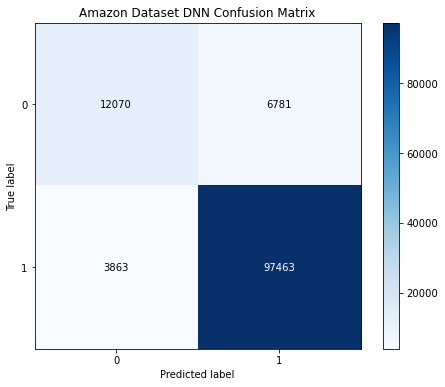

In [28]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_dnn3)
plt.title("Amazon Dataset DNN Confusion Matrix")
plt.rcParams['figure.figsize']=(8,6)
plt.show()